# Bike Sharing Prediction Score RMSLE: 0.64851

# EDA
- Analyze the bike charing test vs training data
- Find intracting point to work on

# Pre-process of data
- Change Weather and Season to one-hot column
- Normlized Values to better Predicition

# Analyze data
- Grid search over XG-BOOST to find best paramaters
- Compare XGB vs Linare regression
- Compare number of Regression algoritms

- Select XGB with optimal paramter

# Submit
- get score of 0.47290



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn import preprocessing

from matplotlib import cm
from matplotlib.ticker import LinearLocator




#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

In [2]:
import os
start_path = ""
if os.path.exists('/kaggle/input/bike-sharing-demand'):
    start_path = "/kaggle/input/bike-sharing-demand/"


train_df=pd.read_csv(start_path+'train.csv')
test_df=pd.read_csv(start_path+'test.csv')



seed=1


In [3]:
df = pd.concat([train_df,test_df])

In [4]:
df.columns.unique()


Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [5]:
df.corr()['count'].drop('count').sort_values()

humidity     -0.317371
weather      -0.128655
holiday      -0.005393
workingday    0.011594
windspeed     0.101369
season        0.163439
atemp         0.389784
temp          0.394454
casual        0.690414
registered    0.970948
Name: count, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.7+ MB


In [7]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [8]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


sesson - [1,2,3,4]
holiday = 0,1 mostly 0
workingday = 0,1 mostly 1
weather = 1,2,3,4 mostly 2-1

temp - [0.82..41] mostly bellow 27
atemp = [0..50] mostly bellow 31

humidity = 0..100 
windspeed = 0..56 mostly bellow 7..16
casual = 0..367 mostly bellow 49

registered = 0..886 mostly bellow 222
count = 1..977 msotly bellow 284


In [9]:
def type_of_fields(df):
    df['season'] = df['season'].astype('category')
    df['holiday'] = df['holiday'].astype('bool')
    df['workingday'] = df['workingday'].astype('bool')
    df['weather'] = df['weather'].astype('category')
    return df

print(train_df.info())
train_df = type_of_fields(train_df)
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season 

In [10]:
df.describe()
#the remove change of type to bool made holiday and workday to be removed from describe output

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


## Idea
- most of the fields can be change into full numbers fields
convery to int instead of float




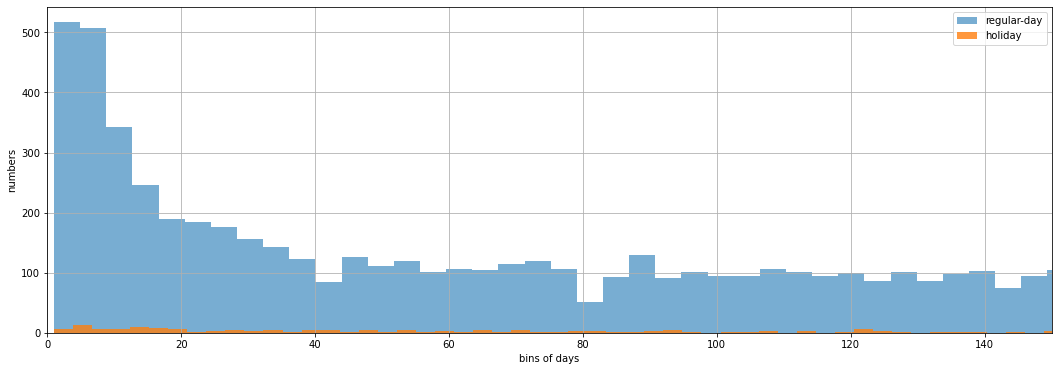

In [11]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 250
plt.hist(train_df[train_df['holiday'] == 0]['count'], alpha = 0.6, bins=bins, label='regular-day')
plt.hist(train_df[train_df['holiday'] == 1]['count'], alpha = 0.8, bins=bins, label='holiday')
plt.xlabel('bins of days')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


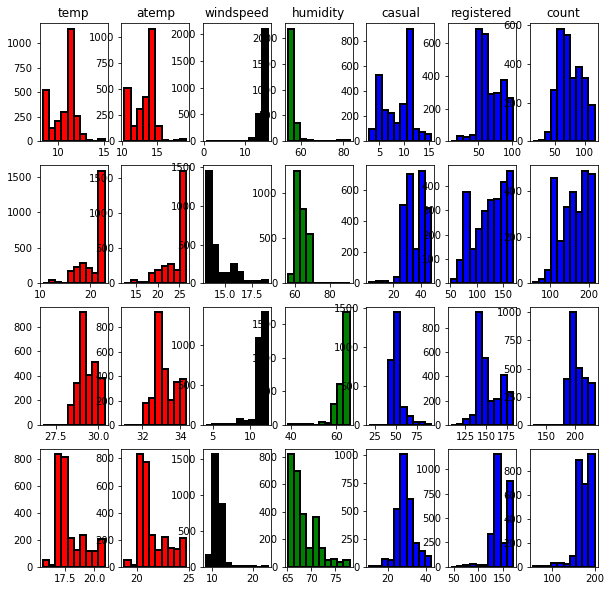

In [12]:
fig,axes=plt.subplots(4,7)
for i in range(4):
    df = train_df[train_df['season'] == i+1]
    df = df.expanding(min_periods=10).mean()
    axes[i,0].hist(x="temp",data=df,edgecolor="black",linewidth=2,color='red')
    axes[0,0].set_title("temp")
    axes[i,1].hist(x="atemp",data=df,edgecolor="black",linewidth=2,color='red')
    axes[0,1].set_title("atemp")
    axes[i,2].hist(x="windspeed",data=df,edgecolor="black",linewidth=2,color='black')
    axes[0,2].set_title("windspeed")
    axes[i,3].hist(x="humidity",data=df,edgecolor="black",linewidth=2,color='green')
    axes[0,3].set_title("humidity")
    axes[i,4].hist(x="casual",data=df,edgecolor="black",linewidth=2,color='blue')
    axes[0,4].set_title("casual")
    axes[i,5].hist(x="registered",data=df,edgecolor="black",linewidth=2,color='blue')
    axes[0,5].set_title("registered")
    axes[i,6].hist(x="count",data=df,edgecolor="black",linewidth=2,color='blue')
    axes[0,6].set_title("count")
fig.set_size_inches(10,10)



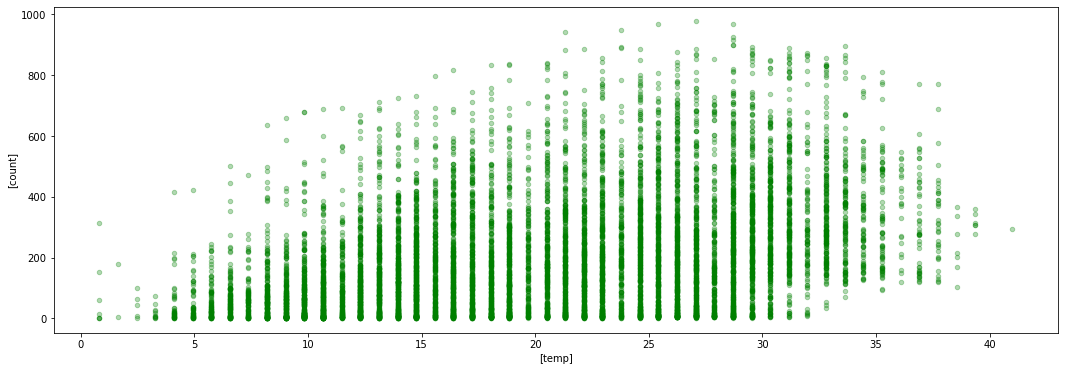

In [13]:
train_df.plot.scatter(x=["temp"], y=['count'], alpha=0.3, color='green')

In [14]:


def add_datepart(df, field_name, prefix=None, drop=False, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    df[prefix+field_name] = pd.to_datetime(df[field_name], infer_datetime_format=True)
    field = df[prefix+field_name]
    attr = ['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
    'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        if (prefix+n not in df):
            df[prefix + n] = getattr(field.dt, n.lower())
    # Pandas removed `dt.week` in v1.1.10
    if (prefix+"Week" not in df):
        week = field.dt.isocalendar().week if hasattr(field.dt, 'isocalendar') else field.dt.week
        df[prefix+'Week'] = week.astype(np.int32)
    mask = ~field.isna()
#     df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,None)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

# Convery dates to year,mount,day column
def add_year_day_to_df(test_df):
    test_df["dt_hour"] = [t.hour for t in pd.DatetimeIndex(test_df.datetime)]
#     test_df["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_df.datetime)]
#     test_df["month"] = [t.month for t in pd.DatetimeIndex(test_df.datetime)]
    test_df['year'] = [t.year for t in pd.DatetimeIndex(test_df.datetime)]
    test_df['year'] = test_df['year'].map({2011:0, 2012:1})
    test_df = add_datepart(test_df, 'datetime', prefix="dt_")
    test_df['date_day_idx'] = test_df['year']*365+test_df['dt_Dayofyear']
    test_df['date_day_idx'] -= min(test_df['date_day_idx'])
    test_df['date_hour_idx'] = test_df['date_day_idx']*24+test_df['dt_hour']
#     test_df.drop('datetime',axis=1,inplace=True)
    return test_df


train_df = add_year_day_to_df(train_df)
test_df = add_year_day_to_df(test_df)
df = pd.concat([train_df, test_df])


remove_fields = []
# remove_fields.append('dt_Year')
remove_fields.append('datetime')
remove_fields.append('dt_datetime')
remove_fields.append('casual')
remove_fields.append('registered')
remove_fields.append('count')


test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             6493 non-null   object        
 1   season               6493 non-null   int64         
 2   holiday              6493 non-null   int64         
 3   workingday           6493 non-null   int64         
 4   weather              6493 non-null   int64         
 5   temp                 6493 non-null   float64       
 6   atemp                6493 non-null   float64       
 7   humidity             6493 non-null   int64         
 8   windspeed            6493 non-null   float64       
 9   dt_hour              6493 non-null   int64         
 10  year                 6493 non-null   int64         
 11  dt_datetime          6493 non-null   datetime64[ns]
 12  dt_Year              6493 non-null   int64         
 13  dt_Month             6493 non-nul

In [15]:
# test_df['year']*365+test_df['dt_Dayofyear']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             17379 non-null  object        
 1   season               17379 non-null  int64         
 2   holiday              17379 non-null  int64         
 3   workingday           17379 non-null  int64         
 4   weather              17379 non-null  int64         
 5   temp                 17379 non-null  float64       
 6   atemp                17379 non-null  float64       
 7   humidity             17379 non-null  int64         
 8   windspeed            17379 non-null  float64       
 9   casual               10886 non-null  float64       
 10  registered           10886 non-null  float64       
 11  count                10886 non-null  float64       
 12  dt_hour              17379 non-null  int64         
 13  year                 17379 non-n

Text(0.5, 1.0, 'The influence of hour(holiday)')

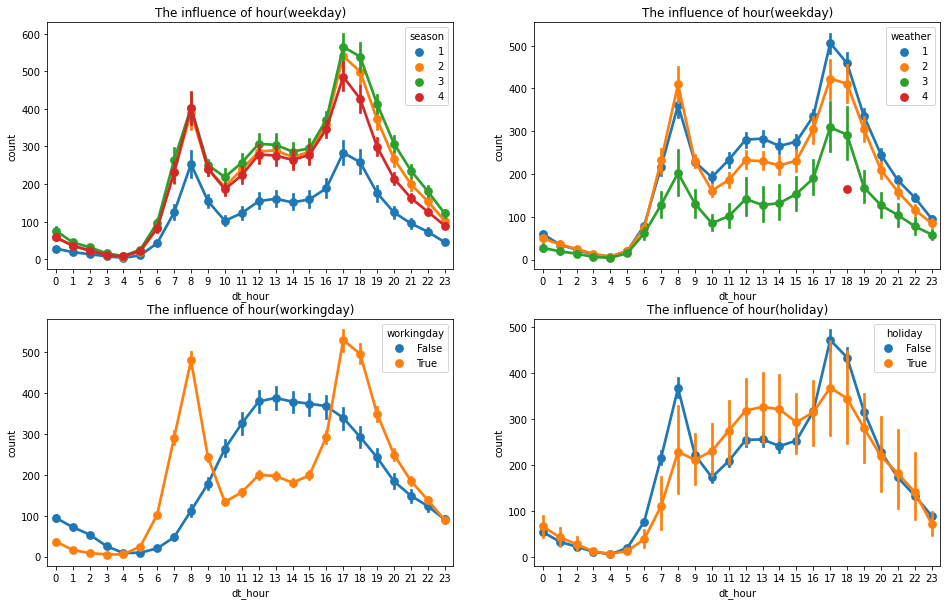

In [16]:
fig, axes = plt.subplots(2,2,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
sns.pointplot(x=train_df['dt_hour'] , y=train_df['count'] , hue = train_df['season'] , ax = ax11)
ax11.set_title('The influence of hour(weekday)')

ax12 = plt.subplot(2,2,2)
sns.pointplot(x=train_df['dt_hour'] , y=train_df['count'] , hue = train_df['weather'] , ax = ax12)
ax12.set_title('The influence of hour(weekday)')

ax2 = plt.subplot(2,2,3)
sns.pointplot(x=train_df['dt_hour'] , y=train_df['count'] , hue = train_df['workingday'] , ax = ax2)
ax2.set_title('The influence of hour(workingday)')

ax3 = plt.subplot(2,2,4)
sns.pointplot(x=train_df['dt_hour'] , y=train_df['count'] , hue = train_df['holiday'] , ax = ax3)
ax3.set_title('The influence of hour(holiday)')

In [17]:
[df['datetime'].min(),df['datetime'].max()]

['2011-01-01 00:00:00', '2012-12-31 23:00:00']

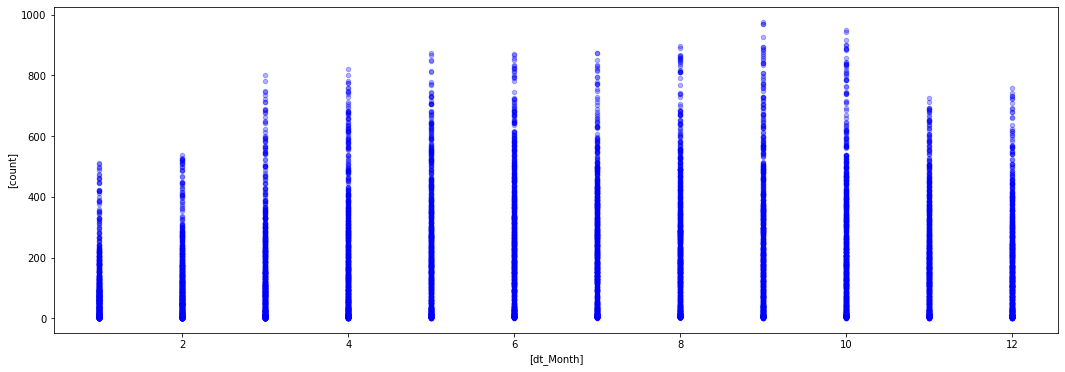

In [18]:
train_df.plot.scatter(x=["dt_Month"], y=['count'], alpha=0.3, color='blue')

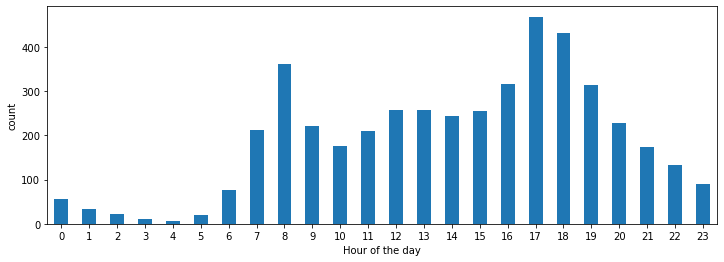

In [19]:
fig, axs = plt.subplots(figsize=(12, 4))
train_df.groupby(train_df["dt_hour"])["count"].mean().plot(kind='bar',rot=0,ax=axs)
plt.xlabel("Hour of the day");  # custom x label using matplotlib
plt.ylabel("count");

In [20]:
#how many uniqe values i got per field
print(df.nunique())
# do we have then a way to translate it into easier to use numbers - normilze 
train_df.value_counts()

datetime               17379
season                     4
holiday                    2
workingday                 2
weather                    4
temp                      50
atemp                     65
humidity                  89
windspeed                 30
casual                   309
registered               731
count                    822
dt_hour                   24
year                       2
dt_datetime            17379
dt_Year                    2
dt_Month                  12
dt_Day                    31
dt_Dayofweek               7
dt_Dayofyear             366
dt_Is_month_end            2
dt_Is_month_start          2
dt_Is_quarter_end          2
dt_Is_quarter_start        2
dt_Is_year_end             2
dt_Is_year_start           2
dt_Week                   52
date_day_idx             456
date_hour_idx          10911
dtype: int64


datetime             season  holiday  workingday  weather  temp   atemp   humidity  windspeed  casual  registered  count  dt_hour  year  dt_datetime          dt_Year  dt_Month  dt_Day  dt_Dayofweek  dt_Dayofyear  dt_Is_month_end  dt_Is_month_start  dt_Is_quarter_end  dt_Is_quarter_start  dt_Is_year_end  dt_Is_year_start  dt_Week  date_day_idx  date_hour_idx
2012-12-19 23:00:00  4       False    True        1        13.12  16.665  66        8.9981     4       84          88     23       1     2012-12-19 23:00:00  2012     12        19      2             354           False            False              False              False                False           False             51       718           17255            1
2011-09-01 23:00:00  3       False    True        1        26.24  30.305  65        16.9979    15      111         126    23       0     2011-09-01 23:00:00  2011     9         1       3             244           False            True               False              False  

## process
remove field from each column and try to predict its values


#process
- use knn or other unsuprvised method to detect groups
- translate those groups as feature



# data
- per month we have max and min sold items
- temp can be convery by *10 and -min values -> will create int


#normlize
- should i normlize per all values or per hour of the or month since at night or day we got diffrent values
- normlize to geosian or uniformal why the diffrent?
- running avrage


# test vs train
what are the diffrenses between the two?


In [21]:
#change season to one hot
import sklearn.preprocessing
def update_feature_with_convert(df):
    for x in ['season','weather']:
        if (x+'_1' not in df):
            tmp_df = pd.get_dummies(df[x], prefix=x)
            df = pd.concat([df,tmp_df], axis=1)
            if (x in df):
                df = df.drop(x,axis=1)
    return df

train_df = update_feature_with_convert(train_df)
test_df = update_feature_with_convert(test_df)
df = update_feature_with_convert(df)

df.info()

T_count={}
T_count['max'] = (train_df['count'].max())
T_count['min'] = (train_df['count'].min())
T_count['min'] = 0
T_count['max'] = T_count['max']*1.05
T_count

a=train_df['count']
aa = (a - T_count['min']) / (T_count['max']-T_count['min'])
train_df['count'] = aa
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
aaa = aa * (T_count['max']-T_count['min']) + T_count['min']
#X_scaled = X_std * (max - min) + min
print(max(a)," ", max(aaa))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             17379 non-null  object        
 1   holiday              17379 non-null  int64         
 2   workingday           17379 non-null  int64         
 3   temp                 17379 non-null  float64       
 4   atemp                17379 non-null  float64       
 5   humidity             17379 non-null  int64         
 6   windspeed            17379 non-null  float64       
 7   casual               10886 non-null  float64       
 8   registered           10886 non-null  float64       
 9   count                10886 non-null  float64       
 10  dt_hour              17379 non-null  int64         
 11  year                 17379 non-null  int64         
 12  dt_datetime          17379 non-null  datetime64[ns]
 13  dt_Year              17379 non-n

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch



n_splits=5


# x = train_df.sample(n=1000, weights='count')
print(remove_fields)
X = train_df.drop(remove_fields,axis=1)
y = train_df['count']

print(X.head())
print(X.shape)
print(y.head())
print(y.shape)
time_splits = TimeSeriesSplit(n_splits=n_splits)
index = 1
for train_index, test_index in time_splits.split(X):
    print("train:",[min(train_index),max(train_index)]," test:",[min(test_index),max(test_index)] )




['datetime', 'dt_datetime', 'casual', 'registered', 'count']
   holiday  workingday  temp   atemp  humidity  windspeed  dt_hour  year  \
0    False       False  9.84  14.395        81        0.0        0     0   
1    False       False  9.02  13.635        80        0.0        1     0   
2    False       False  9.02  13.635        80        0.0        2     0   
3    False       False  9.84  14.395        75        0.0        3     0   
4    False       False  9.84  14.395        75        0.0        4     0   

   dt_Year  dt_Month  ...  date_day_idx  date_hour_idx  season_1  season_2  \
0     2011         1  ...             0              0         1         0   
1     2011         1  ...             0              1         1         0   
2     2011         1  ...             0              2         1         0   
3     2011         1  ...             0              3         1         0   
4     2011         1  ...             0              4         1         0   

   season_3  

In [23]:

def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

#Make RLSME Scorer
def rmsle(predicted, actual):
    return np.sqrt(np.square(np.log(predicted + 1) - np.log(actual + 1)).mean())

from sklearn.metrics import make_scorer
scorer= make_scorer(rmsle, greater_is_better=False)


#Train some model on the data
def display_scores(scores):
    print("Scores:", scores)
    print("Score_mean", scores.mean())
    print("Score_std", scores.std())

In [24]:
#XGBoost hyper-parameter tuning
#https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV


def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'reg_alpha' : [0,0.1,1],
        'reg_lambda' : [0,0.1,1],
        'objective': ['reg:squarederror'],
        # 'tree_method': ['gpu_hist']
        # 'booster' : ['gbtree', 'gblinear']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = scorer,
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = time_splits,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch

#grid_xgb_best = hyperParameterTuning(X, y)
#xgb_best_est = grid_xgb_best.best_estimator_
#grid_xgb_best.best_params_
best_xgb_param = {'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.7};
# xgb_best_est = XGBRegressor(best_xgb_param)

In [25]:
xgb_best_est = XGBRegressor(
        colsample_bylevel=0.7,
        learning_rate= 0.01,
 max_depth = 7,
 min_child_weight = 1,
 n_estimators = 500,
         objective = 'reg:squarederror',
         reg_alpha = 1,
         reg_lambda = 1,
         subsample = 0.7
    )

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate


model_l = {
    'lmodel' : LinearRegression(),
    'xg_boost_best' : xgb_best_est,
    'xg_boost' : xgb.XGBRegressor(),
}
result={}

yy = list(set(y.values))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, random_state=seed)
for m in model_l:
    print(f"Start {m}")
    lmodel = model_l[m]
    result[m]={}

    
    lmodel.fit(X_train, y_train)
    cv_scores = cross_val_score(lmodel, X, y, cv=time_splits, scoring=scorer)
    print("Cross val:",cv_scores, cv_scores.mean())
    result[m]['mean']=cv_scores.mean()
    idx=0
    for train_index, test_index in time_splits.split(X):
        print("train:",[min(train_index),max(train_index)]," test:",[min(test_index),max(test_index)] ," score:",cv_scores[idx])
        idx+=1

    if (m in ['lmodel']):
        # print the coefficients
        print("itercept:",lmodel.intercept_)
        for x_idx, x_col_name in enumerate(X_train.columns):
            print(f"itercept {x_col_name:20} {round(lmodel.coef_[x_idx],5):10}")
    if (m in ['xg_boost']):
        for x_idx, feature_imp in zip(X_train.columns, lmodel.feature_importances_):
            print(f"itercept {x_idx:20} {round(feature_imp,5):10}")
        
    # for train_index, test_index in splits.split(X):
    #     print("train:",[min(train_index),max(train_index)]," test:",[min(test_index),max(test_index)] )

    lmodel.fit(X_train, y_train)
    pre_train = lmodel.predict(X_train)
    pre_test = lmodel.predict(X_test)
    print("rmsle train:",rmsle(y_train, pre_train))
    result[m]['lrmse_train']=rmsle(y_train, pre_train)
    print("rmsle test:",rmsle(y_test, pre_test))
    result[m]['lrmse']=rmsle(y_test, pre_test)
print(result)



Start lmodel


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Cross val: [-0.10409099 -0.10459163 -0.11211877 -0.13528723 -0.13212757] -0.11764323939473535
train: [0, 1815]  test: [1816, 3629]  score: -0.1040909912655193
train: [0, 3629]  test: [3630, 5443]  score: -0.10459162922040839
train: [0, 5443]  test: [5444, 7257]  score: -0.11211877318445626
train: [0, 7257]  test: [7258, 9071]  score: -0.13528723451161476
train: [0, 9071]  test: [9072, 10885]  score: -0.13212756879167808
itercept: 0.18164931939346476
itercept holiday                -0.00878
itercept workingday              0.00234
itercept temp                    0.00534
itercept atemp                   0.00268
itercept humidity               -0.00188
itercept windspeed               0.00051
itercept dt_hour                 0.00752
itercept year                     -2e-05
itercept dt_Year                  -2e-05
itercept dt_Month               -0.18598
itercept dt_Day                 -0.00618
itercept dt_Dayofweek            0.00141
itercept dt_Dayofyear            0.00626
itercept dt_I

In [27]:

# Machine learning pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier



In [28]:
def create_baseline_classifiers(seed=1):
    """Create a list of baseline classifiers.
    
    Parameters
    ----------
    seed: (optional) An integer to set seed for reproducibility

    Returns
    -------
    A list containing tuple of name, model object for each of these algortihms:
    DummyClassifier, LogisticRegression, SGDClassifier, ExtraTreesClassifier, 
    GradientBoostingClassifier, RandomForestClassifier, MultinomialNB, SVC, 
    XGBClassifier.
    
    """
    models = []
    models.append(('dum', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('log', LogisticRegression(random_state=seed)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('etc', ExtraTreesClassifier(random_state=seed)))
    models.append(('gbm', GradientBoostingClassifier(random_state=seed)))
    models.append(('rfc', RandomForestClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    models.append(('svc', SVC(random_state=seed, probability=True)))
    models.append(('xgb', XGBClassifier(seed=seed)))
    return models

def assess_models(X, y, models, cv=5, metrics=['roc_auc', 'f1'],scorer={}):
    """Provide summary of cross validation results for models.
    
    Parameters
    ----------
    X: A pandas DataFrame containing feature matrix
    y: A pandas Series containing target vector
    models: A list of models to train
    cv: (optional) An integer to set number of folds in cross-validation
    metrics: (optional) A list of scoring metrics or a string for a metric

    Returns
    -------
    A pandas DataFrame containing summary of baseline models' performance.
    
    """
    summary = pd.DataFrame()
    for name, model in models:
        cross_validate_val = cross_validate(model, X, y, cv=cv, scoring=metrics)
        # print("1 cross_validate_val:\n",cross_validate_val)
        for scorer_name in scorer:
            result1 = cross_val_score(model, X, y, cv=time_splits, scoring=scorer[scorer_name])
            cross_validate_val[scorer_name] = result1
            # print("result1:",result1)
        # print("2 cross_validate_val:\n",cross_validate_val)
        result = pd.DataFrame(cross_validate_val)
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        min1 = result.min().rename('{}_min'.format)
        max1 = result.max().rename('{}_max'.format)

        summary[name] = pd.concat([mean, std, max1, min1], axis=0)


    return summary.sort_index()

def extract_metric(summary, metric):
    """Provide summary of baseline models' performance for a metric.
    
    Parameters
    ----------
    summary: A pandas DataFrame containing the summary of baseline models
    metric: A string specifying the name of the metric to extract info
    
    Returns
    -------
    A pandas DataFrame containing mean, standard deviation, lower and upper
    bound of the baseline models' performance in cross validation according to
    the metric specified.
    
    """
    output = summary[summary.index.str.contains(metric)].T
    output.columns = output.columns.str.replace(f'test_{metric}_', '')
    output.sort_values(by='mean', ascending=False, inplace=True)
    output['lower'] = output['mean'] - 2*output['std']
    output['upper'] = output['mean'] + 2*output['std']
    return output


In [29]:
# Set target
target = 'count'
features = X.columns

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, random_state=seed)

# Inspect data
print(f"Training data ({X_train.shape[0]} rows): Target distribution")
# print(y_train.value_counts(normalize=True))
print(f"\nTest data ({X_test.shape[0]} rows): Target distribution")
# print(y_train.value_counts(normalize=True))



Training data (8708 rows): Target distribution

Test data (2178 rows): Target distribution


In [30]:
# models = create_baseline_classifiers(seed=seed)
# summary = assess_models(X_train, y_train, models, cv=time_splits, metrics=['r2','neg_mean_absolute_error','neg_root_mean_squared_error','neg_mean_squared_log_error'])
# summary

In [31]:

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

def create_baseline_regressors(seed=8):
    """Create a list of of baseline regressors.
    
    Parameters
    ----------
    seed: (optional) An integer to set seed for reproducibility

    Returns
    -------
    A list containing tuple of name, model object for each of these algortihms:
    DummyRegressor, LinearRegression, SGDRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, RandomForestRegressor, SVR, XGBRegressor.
    
    """
    models = []
    models.append(('dum', DummyRegressor(strategy='mean')))
    models.append(('ols', LinearRegression()))
    models.append(('sgd', SGDRegressor(random_state=seed)))
    models.append(('etr', ExtraTreesRegressor(random_state=seed)))
    models.append(('gbm', GradientBoostingRegressor(random_state=seed)))
    models.append(('rfr', RandomForestRegressor(random_state=seed)))
    models.append(('svc', SVR()))
    models.append(('xgb', XGBRegressor(seed=seed)))
    models.append(('xgb_best', xgb_best_est))
    return models


models_reg = create_baseline_regressors(seed=seed)
summary_reg = assess_models(X_train, y_train, models_reg, cv=time_splits, metrics=['max_error','r2','neg_mean_absolute_error','neg_median_absolute_error'], scorer={'LRSME':scorer})


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


[20:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [32]:
summary_reg

,dum,ols,sgd,etr,gbm,rfr,svc,xgb,xgb_best
LRSME_max,-1.369429e-01,-0.104420,-3.311064e+01,-0.029757,-0.048105,-0.032420,-0.126121,-0.049237,-0.035627
LRSME_mean,-1.387618e-01,-0.107399,-3.468771e+01,-0.034901,-0.050853,-0.036681,-0.127794,-0.050902,-0.042076
LRSME_min,-1.409010e-01,-0.110482,-3.657707e+01,-0.041555,-0.054029,-0.047161,-0.132059,-0.052150,-0.055325
LRSME_std,1.437279e-03,0.002457,1.532235e+00,0.005025,0.002425,0.006336,0.002435,0.001119,0.007832
fit_time_max,2.800226e-03,0.032833,4.608729e-01,3.579511,1.560817,5.670985,3.250794,0.815163,7.876369
fit_time_mean,2.033567e-03,0.022163,2.042356e-01,2.178585,0.948382,3.374576,1.467099,0.502436,4.753321
fit_time_min,1.719952e-03,0.013189,4.498267e-02,0.777379,0.351129,1.137188,0.159012,0.184560,1.640098
fit_time_std,4.408825e-04,0.008068,1.624445e-01,1.109165,0.479590,1.796670,1.242010,0.247556,2.479522
score_time_max,1.486778e-03,0.009007,9.767532e-03,0.071878,0.013065,0.061592,0.326723,0.014074,0.059914
score_time_mean,1.370144e-03,0.008901,9.341145e-03,0.059651,0.012436,0.051286,0.208932,0.013957,0.057720


In [33]:
clf_rf = xgb_best_est
clf_rf.fit(X,y)
pred=clf_rf.predict(test_df.drop(['datetime', 'dt_datetime'],axis=1))
print(pred.shape)

# add a min-max per date&time perdiction fixer
pred_post = abs(pred) * (T_count['max']-T_count['min']) + T_count['min']
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

print(pred_post.shape)
d={'datetime':test_df['datetime'],'count':pred_post}
ans=pd.DataFrame(d)
ans.to_csv('submission.csv',index=False) # saving to a csv file for predictions.

(6493,)
(6493,)
